In [73]:
##Dataset url: https://grouplens.org/datasets/movielens/latest/


import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns


In [74]:
movies_df = pd.read_csv('movies.csv',usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
rating_df=pd.read_csv('ratings.csv',usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [75]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [76]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.000
1,1,3,4.000
2,1,6,4.000
3,1,47,5.000
4,1,50,5.000


In [77]:
df = pd.merge(rating_df,movies_df,on='movieId')
df.head()

,userId,movieId,rating,title
0,1,1,4.000,Toy Story (1995)
1,5,1,4.000,Toy Story (1995)
2,7,1,4.500,Toy Story (1995)
3,15,1,2.500,Toy Story (1995)
4,17,1,4.500,Toy Story (1995)


In [78]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()


,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [79]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.000,Toy Story (1995),215
1,5,1,4.000,Toy Story (1995),215
2,7,1,4.500,Toy Story (1995),215
3,15,1,2.500,Toy Story (1995),215
4,17,1,4.500,Toy Story (1995),215
...,...,...,...,...,...
100831,610,160341,2.500,Bloodmoon (1997),1
100832,610,160527,4.500,Sympathy for the Underdog (1971),1
100833,610,160836,3.000,Hazard (2005),1
100834,610,163937,3.500,Blair Witch (2016),1


In [80]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   9719.000
mean      10.375
std       22.406
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRatingCount, dtype: float64


In [81]:
popularity_threshold = 50

query_string = f'totalRatingCount >= {popularity_threshold}'
rating_popular_movie = rating_with_totalRatingCount.query(query_string)
rating_popular_movie

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.000,Toy Story (1995),215
1,5,1,4.000,Toy Story (1995),215
2,7,1,4.500,Toy Story (1995),215
3,15,1,2.500,Toy Story (1995),215
4,17,1,4.500,Toy Story (1995),215
...,...,...,...,...,...
79246,603,1997,4.000,"Exorcist, The (1973)",53
79247,606,1997,3.000,"Exorcist, The (1973)",53
79248,607,1997,5.000,"Exorcist, The (1973)",53
79249,608,1997,4.500,"Exorcist, The (1973)",53


In [82]:
rating_popular_movie.shape

(41362, 5)

In [83]:
#creating mean ratings data
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.000
'Hellboy': The Seeds of Creation (2004),4.000
'Round Midnight (1986),3.500
'Salem's Lot (2004),5.000
'Til There Was You (1997),4.000


In [84]:
#creating number of ratings data
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings.head()

,rating,number_of_ratings
title,,
'71 (2014),4.000,1
'Hellboy': The Seeds of Creation (2004),4.000,1
'Round Midnight (1986),3.500,2
'Salem's Lot (2004),5.000,1
'Til There Was You (1997),4.000,2


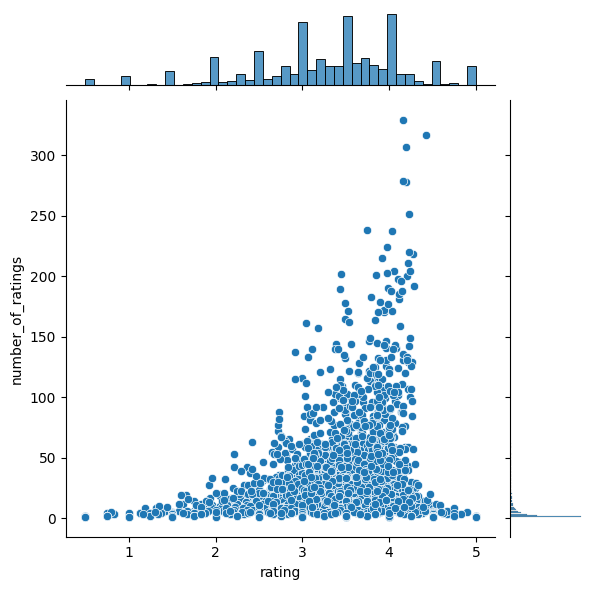

In [85]:
#Plotting the jointplot
import matplotlib.pyplot as plt
%matplotlib inline


sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

In [86]:
## First lets create a Pivot matrix

movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,...,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,...,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2: X-Men United (2003),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,4.000
You've Got Mail (1998),0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,2.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000
Young Frankenstein (1974),5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000


In [87]:
# contains the movie-user rating data in a pivot table format, into a CSR matrix
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

# KNN
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [88]:
movie_features_df.shape

(450, 606)

In [89]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)


80


In [90]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Casablanca (1942):

1: Rear Window (1954), with distance of 0.4529125690460205:
2: Citizen Kane (1941), with distance of 0.4539453387260437:
3: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), with distance of 0.47372424602508545:
4: Godfather, The (1972), with distance of 0.47745490074157715:
5: Graduate, The (1967), with distance of 0.4822031855583191:
6: North by Northwest (1959), with distance of 0.482573926448822:
7: Vertigo (1958), with distance of 0.4948185086250305:
8: It's a Wonderful Life (1946), with distance of 0.4966033697128296:
9: L.A. Confidential (1997), with distance of 0.507091760635376:


Decision tree

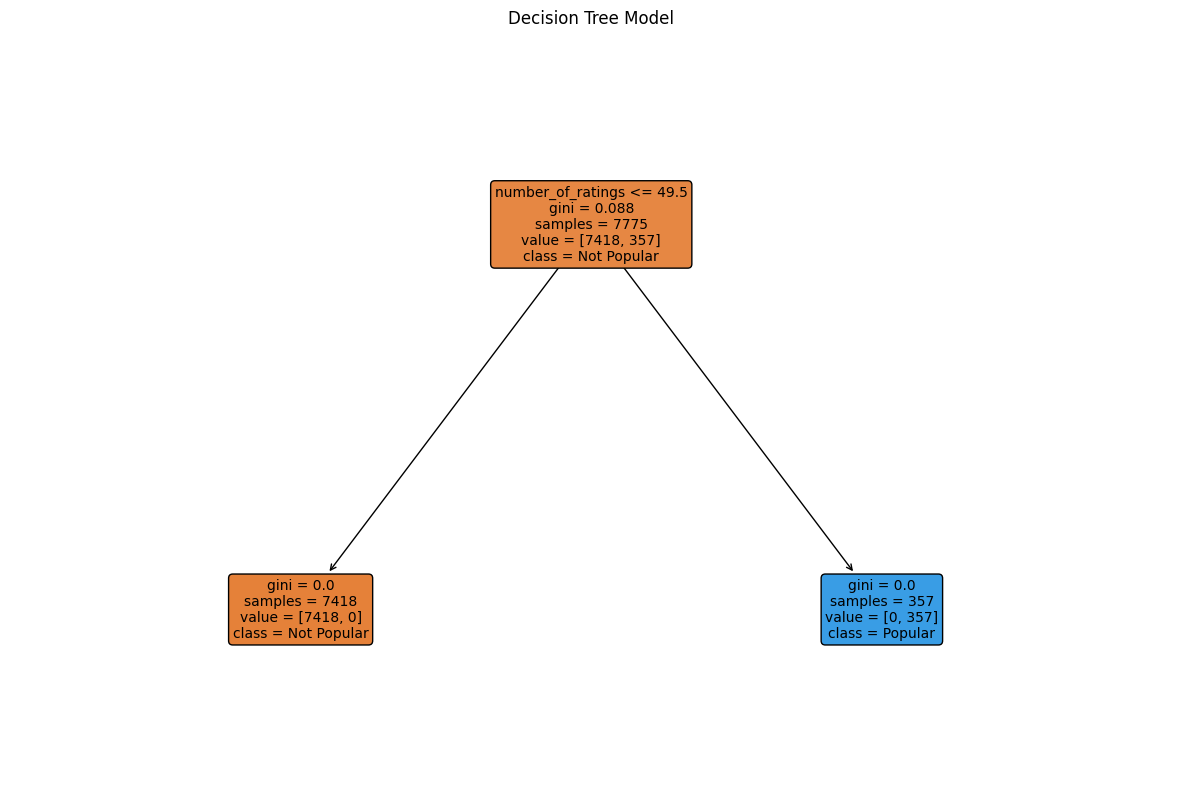

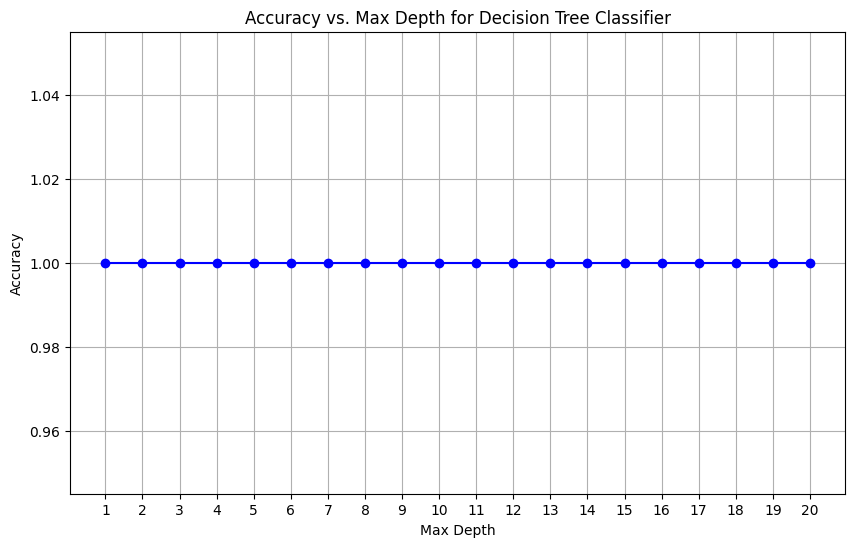

In [ ]:
X = ratings[['rating', 'number_of_ratings']]
y = ratings['number_of_ratings'] >= popularity_threshold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)


plt.figure(figsize=(15, 10))  
plot_tree(clf, feature_names=['rating', 'number_of_ratings'], class_names=['Not Popular', 'Popular'],
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Model")
plt.show()


accuracy = clf.score(X_test, y_test)
max_depth_values = range(1, 21)  # Change as needed

# Initialize lists to store accuracy values
accuracy_values = []

# Vary max_depth and evaluate accuracy for each value
for max_depth in max_depth_values:
    # Train a decision tree classifier with the current max_depth
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    # Evaluate the accuracy on the test set
    accuracy = clf.score(X_test, y_test)
    accuracy_values.append(accuracy)

# Create a plot to visualize accuracy vs. max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Max Depth for Decision Tree Classifier')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(max_depth_values)
plt.show()